In [ ]:
!pip install -q pytorch-lightning wandb

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
from shutil import copyfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b6
from torch.utils.data import DataLoader, RandomSampler

import wandb
from torchmetrics.classification import MulticlassF1Score
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

In [ ]:
sns.set(style='darkgrid', palette='Set2')
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Задача 1. Transfer learning
Научим нейронную сеть классифицировать произведения искусства различных художников, т.е. определять к какому художнику относится картина.

### 1. Данные
Скачаем архив с датасетом по [ссылке](https://disk.yandex.ru/d/_BUueJa4RVXplQ).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/DS/artworks.zip'
!unzip $zip_path -d .
data_path = Path('./artworks')

Данные содержат папку с изображениями `images` и таблицу с основной информацией про художников `artists.csv`. Папка `images` в свою очередь состоит из папок `train` и `test` с обучающим и тестовым наборами данных соответственно. Рассмотрим, например, папку с тренировочным набором данных.

In [ ]:
sorted((data_path / 'images' / 'train').iterdir())

Она содержит папки, соответствующие художникам в датасете. В каждой такой папке находится тренирвочный набор картин художника.

In [ ]:
sorted((data_path / 'images' / 'train' / 'Albrecht_Durer').iterdir())

Приведем примеры изображений.

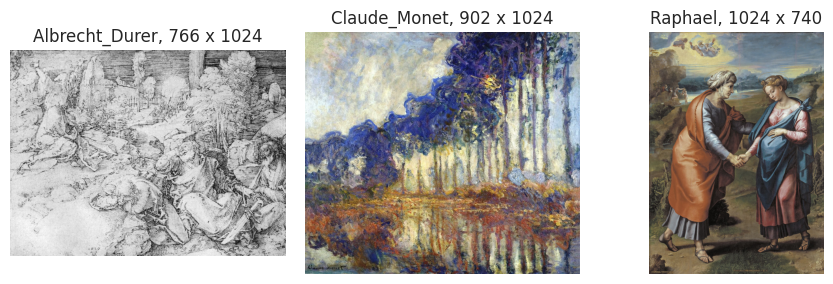

In [ ]:
images_paths = [
    data_path / 'images' / 'train' / 'Albrecht_Durer' / 'Albrecht_Durer_310.jpg',
    data_path / 'images' / 'train' / 'Claude_Monet' / 'Claude_Monet_007.jpg',
    data_path / 'images' / 'train' / 'Raphael' / 'Raphael_100.jpg'
]
plt.figure(figsize=(9, 3))
for i, image_path in enumerate(images_paths):
    author = image_path.parent.name
    plt.subplot(1, 3, i + 1)
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'{author}, {image.shape[0]} x {image.shape[1]}')
    plt.axis("off")
plt.tight_layout()

Заметим, что все картины разных пропорций и размеров, это нужно учесть при обучении модели. Чтобы привести картины к одному размеру можно использовать аугментации.


Теперь посмотрим на таблицу с характеристиками художников.



In [ ]:
artists_df = pd.read_csv(data_path / 'artists.csv')
artists_df.head()

,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


Наша цель &mdash; построить классификатор картин по художникам. В колонке `paintings` указано общее число картин для каждого художника. Можно заметить большую несбалансированность классов. Поэтому в начале мы будем работать с художниками, для которых в сумме представлено не менее 200 картин.

Выберем широко представленных художников.

In [ ]:
freq_artists = artists_df['name'][artists_df['paintings'] >= 200].values
N_CLASSES = len(freq_artists)
freq_artists, N_CLASSES

(array(['Vincent van Gogh', 'Pablo Picasso', 'Pierre-Auguste Renoir',
        'Francisco Goya', 'Albrecht Dürer', 'Alfred Sisley',
        'Marc Chagall', 'Edgar Degas', 'Rembrandt', 'Titian',
        'Paul Gauguin'], dtype=object),
 11)

Нам понадобится определить названия папок для художников.

In [ ]:
freq_artists_dirs = []
for artist in freq_artists:
    if artist == 'Albrecht Dürer':
        artist_dir = 'Albrecht_Durer'
    else:
        artist_dir = '_'.join(artist.split())
    freq_artists_dirs.append(artist_dir)

Выделим папку с художниками, которых мы выбрали ранее и перенесем туда соответствующие изображения, чтобы было возможно воспользоваться ImageFolder.

In [ ]:
images_selected_path = Path('images_selected')
images_selected_path.mkdir(exist_ok=True)
for mode in ['train', 'test']:
    (images_selected_path / mode).mkdir(exist_ok=True)
    for artist_dir in tqdm(freq_artists_dirs):
        (images_selected_path / mode / artist_dir).mkdir(exist_ok=True)
        for file_path in (data_path / 'images' / mode / artist_dir).iterdir():
            copyfile(file_path, images_selected_path / mode / artist_dir / file_path.name)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Определим базовый набор аугментаций. Благодаря им мы приведем все изображения к единому виду: уменьшим так, чтобы наименьшая сторона имела заданный размер, затем вырежем центральный квадрат из изображения и применим нормализацию, которая обычно применяется в случае использования моделей, обученных на ImageNet.

In [ ]:
input_size = 224
simple_transform = transforms.Compose([
    transforms.Resize(input_size),      # Меняем размер картинки, наименьшая из сторон становится размера input_size
    transforms.CenterCrop(input_size),  # Вырезаем квадрат из центра изображения
    transforms.ToTensor(),
    transforms.Normalize(               # Нормализуем картинки в соотвествии со статистикой из ImageNet
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Соберем тренировочный и тестовый датасеты.

In [ ]:
train_dataset = ImageFolder(
    root=images_selected_path / 'train',
    transform=simple_transform,
)
test_dataset = ImageFolder(
    root=images_selected_path / 'test',
    transform=simple_transform,
)
len(train_dataset), len(test_dataset)

(3004, 1295)

Заведем генераторы батчей.

In [ ]:
batch_size = 8
training_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(
        train_dataset,
        replacement=True
    ),
    num_workers=2
)
validation_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=2
)

### 2. Fine-tuning

Будем использовать `EfficientNet_B6`

Создадим класс модели для Pytorch Lightning:

In [ ]:
class FineTunedEfficientNet(LightningModule):
    def __init__(self, to_freeze, n_classes=N_CLASSES, lr=0.001):
        '''Инициализация модели
        * to_freeze -- сколько слоев хотим заморозить, максимум: 9.
        * n_classes -- кол-во классов
        * lr -- learning rate для оптимизатора'''

        super().__init__()
        self.n_classes = n_classes
        self.metric = MulticlassF1Score(num_classes=n_classes, average='macro')
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.save_hyperparameters()

        # списки для сохранения предсказаний и меток
        self.test_y_pred, self.test_y_true = [], []
        self.val_y_pred, self.val_y_true = [], []
        self.train_y_pred, self.train_y_true = [], []

        # зададим модель
        self.model = efficientnet_b6(weights='IMAGENET1K_V1')
        # изменим слой классификатора
        self.model.classifier[1] = nn.Linear(2304, n_classes)
        for i in range(to_freeze): # заморозим to_freeze первых слоев
            for param in self.model.features[i].parameters():
                param.requires_grad = False
        for param in self.model.classifier.parameters(): # разморозим классификатор
            param.requires_grad = True

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def __step(self, batch, list_preds, list_gt, name=None, log_loss=True):
        ''' Один шаг работы с batch.
        * list_preds -- список для сохранения предсказаний
        * list_gt -- список для сохранения истинных меток
        * name -- `train` или `val`
        * log_loss -- логировать ли лосс '''

        x, y = batch
        list_gt.append(y)
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        list_preds.append(preds)
        loss = self.criterion(logits, y)
        if log_loss:
            self.log(name+'_loss', loss) # логируем лосс
        return preds, loss

    def training_step(self, batch, batch_idx):
        '''1 шаг обучения по батчу'''
        _, loss = self.__step(batch, self.train_y_pred, self.train_y_true, name='train')
        return loss

    def validation_step(self, batch, batch_idx):
        '''1 шаг валидации по батчу'''
        preds, _ = self.__step(batch, self.val_y_pred, self.val_y_true, name='val')
        # возвращаем предсказания, чтобы использовать их в callback
        return preds

    def test_step(self, batch, batch_idx):
        '''1 шаг тестирования по батчу'''
        self.__step(batch, self.test_y_pred, self.test_y_true, log_loss=False)

    def __end_epoch(self, list_preds, list_gt, name):
        '''Логирование метрики, очищение сохраненных значений'''
        all_preds = torch.concatenate(list_preds)
        all_gt = torch.concatenate(list_gt)
        self.log(name+'_F1_score', self.metric(all_preds, all_gt))
        list_preds.clear()
        list_gt.clear()

    def on_train_epoch_end(self):
        self.__end_epoch(self.train_y_pred, self.train_y_true, 'train')

    def on_validation_epoch_end(self):
        self.__end_epoch(self.val_y_pred, self.val_y_true, 'val')

    def on_test_epoch_start(self):
        '''Очищение списков перед началом тестирования'''
        self.test_y_pred.clear()
        self.test_y_true.clear()

In [ ]:
class LogPredictionsCallback(Callback):
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx):
        '''Вызывается после валидационного батча.
        `outputs` приходит из `LightningModule.validation_step`,
        что в данном случае соответствует предсказаниям модели'''

        # Будем логировать предсказания для 8 картинок
        if batch_idx == 0:
            n = 8
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # логируем картинки
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)

log_predictions_callback = LogPredictionsCallback()

Попробуем fine-tuning с разным количеством размороженных слоев, достаточно трех вариантов. Сравним ошибку (лосс) и качество (F1 macro) на тренировочной и тестовой частях выборки во время обучения. F1 Score считайте не на каждом батче, а на всей эпохе.

**1. Оценим качество модели, у которой все слои кроме классификатора заморожены.**

In [ ]:
frozen_extractor_model = FineTunedEfficientNet(to_freeze=9)
checkpoint_callback = ModelCheckpoint(monitor='val_F1_score', mode='max')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback, checkpoint_callback],
                  max_epochs=10)
trainer.fit(frozen_extractor_model, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric    | MulticlassF1Score | 0     
1 | criterion | CrossEntropyLoss  | 0     
2 | model     | EfficientNet      | 40.8 M
------------------------------------------------
25.4 K    Trainable params
40.7 M    Non-trainable params
40.8 M    Total params
163.044   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▅▆▇█▇████
train_loss,▇█▅▄▅▇▄▃█▇▆▄▅▄▂▃▃▆▅▅▄▄▄▁▅▂▃▄▃▆▄▅▂▅▃▂▅▅▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_F1_score,▁▄▆▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_F1_score,0.65866
train_loss,0.92658
trainer/global_step,3759
val_F1_score,0.60435


**2. Заморозим теперь только первые 6 из 9 блоков модели.**

Заметим, что стоит смотреть на кол-во обучаемых параметров. Несмотря на то, что мы заморозили большинство слоев, подавляющая часть параметров обучаема, так как последние слои тяжеловесные.

In [ ]:
semi_frozen_model = FineTunedEfficientNet(to_freeze=6)
wandb.init(project='Artworks')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback, checkpoint_callback],
                  max_epochs=10)
trainer.fit(semi_frozen_model, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ./Artworks/utdxmyh4/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▅▆▇▇▇████
train_loss,█▆▄█▃▄▃▃▃▄▂▃▆▃▃▃▁▃▃▃▂▂▁▁▄▁▁▁▂▁▁▁▃▂▆▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_F1_score,▁▅█▇████▇▇
val_loss,█▃▁▂▁▁▂▂▂▃
epoch,9
train_F1_score,0.94346
train_loss,0.01428
trainer/global_step,3759
val_F1_score,0.79926


**3. Оценим качество модели, у которой все слои разморожены.**

In [ ]:
unfrozen_model = FineTunedEfficientNet(to_freeze=0)
wandb.init(project='Artworks')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback,checkpoint_callback],
                  max_epochs=10)
trainer.fit(unfrozen_model, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric    | MulticlassF1Score | 0     
1 | criterion | CrossEntropyLoss  | 0     
2 | model     | EfficientNet      | 40.8 M
------------------------------------------------
40.8 M    Trainable params
0         Non-trainable params
40.8 M    Total params
163.044   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▄▆▆▇▇████
train_loss,█▅▃▅▅▂▃▃▅▃▄▂▃▄▄▁▂▄▄▃▁▅▁▁▁▃▄▁▄▁▃▃▅▂▂▁▄▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_F1_score,▁▂▆▅▄█▇▇▇▅
val_loss,▇█▁▄▅▁▃▃▂▅
epoch,9
train_F1_score,0.91613
train_loss,0.11872
trainer/global_step,3759
val_F1_score,0.71024


**Вывод:**
* Метрика F1 хороша тем, что она уравновешивает Precision и Recall. Благодаря методу усреднения macro мы уделяем внимание каждому классу одинаково, вне зависимости от того, как широко он представлен в данных.

* Лучшая метрика у данной сети за 10 эпох &mdash; у модели с 6 замороженными слоями. Вероятнее всего полностью размороженная модель не успела обучиться, ведь у нее на 8 миллионов больше обучаемых параметров. В целом, метрика на текущей стадии все еще нестабильна, и может быть такое, что качества моделей `semi-frozen` и `unfrozen` статистически неотличимы.

### 3. Аугментации

Для улучшения качества модели можно расширить обучающую выборку. Это можно сделать с помощью аугментации данных. Какие аугментации здесь будут полезны?

**Ответ:** Аугментации должны быть такими, чтобы не поменялся стиль автора. Во многом стиль зависит от выбранной цветовой палитры, яркости и контрастности изображений. Поэтому будем  в основном использовать аугментации которые изменяют размер и форму, а цвета изменим минимально.

Добавьте аугментации к данным. Визуализируйте несколько аугментированных изображений.

In [ ]:
input_size = 224
complex_transform_unnorm = transforms.Compose([
    transforms.RandomResizedCrop(size=input_size, scale=(0.7, 1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])
complex_transform = transforms.Compose([
    complex_transform_unnorm,
    transforms.Normalize(  # Нормализуем картинки в соотвествии со статистикой из ImageNet
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

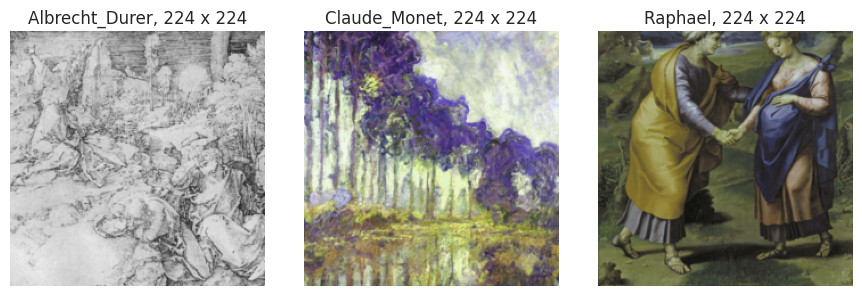

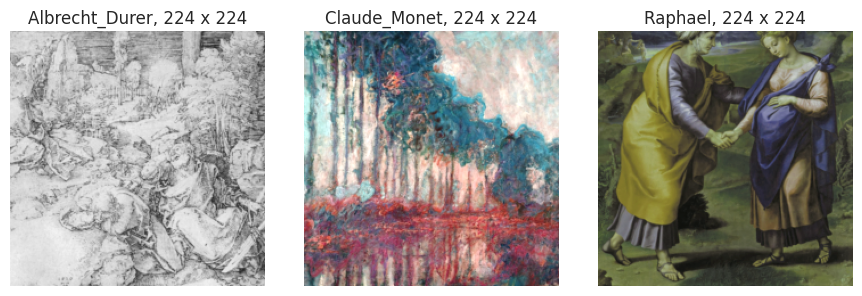

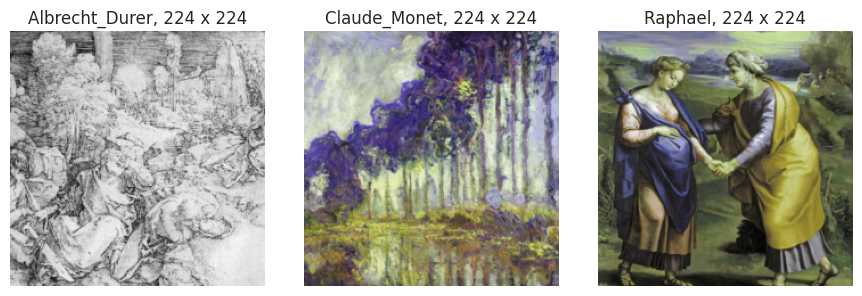

In [ ]:
for _ in range(3):
    plt.figure(figsize=(9, 3))
    for i, image_path in enumerate(images_paths):
        author = image_path.parent.name
        plt.subplot(1, 3, i + 1)
        image = Image.open(image_path)
        trans_image = complex_transform_unnorm(image).moveaxis(0, 2)
        plt.imshow(trans_image)
        plt.title(f'{author}, {trans_image.shape[0]} x {trans_image.shape[1]}' )
        plt.axis("off")
    plt.tight_layout()

Выберем лучшую модель. Применим fine-tuning модели
 на аугментированных данных.

In [ ]:
train_dataset = ImageFolder(
    root=images_selected_path / 'train',
    transform=complex_transform,
)

training_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(
        train_dataset,
        replacement=True
    )
)

Обучим `semi_frozen_model` на аугментированных данных.

In [ ]:
semi_frozen_model = FineTunedEfficientNet(to_freeze=6)
wandb.init(project='Artworks')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback, checkpoint_callback],
                  max_epochs=10)
trainer.fit(semi_frozen_model, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric    | MulticlassF1Score | 0     
1 | criterion | CrossEntropyLoss  | 0     
2 | model     | EfficientNet      | 40.8 M
------------------------------------------------
32.9 M    Trainable params
7.9 M     Non-trainable params
40.8 M    Total params
163.044   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▄▆▇▇▇████
train_loss,█▄▅▆▅▅▃▂▂▃▆▃▃▄▂▁▂▁▃▁▁▃▅▁▁▁▁▁▁▂▁▂▃▂▁▁▁▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_F1_score,▁▅▆▆██▇▇██
val_loss,█▄▂▃▁▁▂▂▂▁
epoch,9
train_F1_score,0.91288
train_loss,0.22615
trainer/global_step,3759
val_F1_score,0.84117


**Вывод:** Удалось поднять метрику с `0.79926` до `0.84117`. Метрика на обучении при этом была стабильно меньше и ближе к валидации, эффект переобучения меньше. Аугментации позволили расширить обучающую выборку для модели, что привело к улучшению качества.

### 4. Несбалансированность классов
Расширим выборку до всех классов. Применим fine-tuning для расширенной выборки.

In [ ]:
train_dataset = ImageFolder(
    root=data_path / 'images' / 'train',
    transform=complex_transform,
)
test_dataset = ImageFolder(
    root=data_path / 'images' / 'test',
    transform=simple_transform,
)
training_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(
        train_dataset,
        replacement=True
    ),
    num_workers=2
)
validation_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=2
)
len(train_dataset.classes)

50

Обучим модель без заморозки слоев:

In [ ]:
full_model = FineTunedEfficientNet(to_freeze=0, n_classes=50)
wandb.init(project='Artworks')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback, checkpoint_callback],
                  max_epochs=10)
trainer.fit(full_model, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ./Artworks/utdxmyh4/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Среднее качество модели, обученной на большем количестве классов, оказалось хуже.

In [ ]:
def test_freq_rare_classes(model, trainer):
    '''Сравнивает F1 Score для широко и редко - представленных классов
    * model -- модель для тестирования
    * trainer -- трейнер, которым она обучалась'''

    # тестируем модель - для этого в model должен быть test_step()
    trainer.test(model, dataloaders=validation_loader)
    y_pred = np.concatenate([t.cpu().numpy() for t in model.test_y_pred])
    y_true = np.concatenate([t.cpu().numpy() for t in model.test_y_true])

    # freq_mask - маска для таргета, freq_classes - индексы частых
    freq_classes_mask = np.isin(train_dataset.classes, freq_artists_dirs)
    freq_classes = np.arange(50)[freq_classes_mask]
    rare_classes = np.arange(50)[~freq_classes_mask]
    freq_mask = np.isin(y_true, freq_classes)

    # вычисляем F1 Score
    freq = f1_score(y_pred[freq_mask], y_true[freq_mask],
                    labels=freq_classes, average='macro')
    rare = f1_score(y_pred[~freq_mask], y_true[~freq_mask],
                    labels=rare_classes, average='macro')
    print("F1 Score для широко представленных классов:\t", freq)
    print("F1 Score для редко представленных классов:\t", rare)

Сравним метрики для широко представленных художников и редко представленных.

In [ ]:
test_freq_rare_classes(full_model, trainer)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

F1 Score для широко представленных классов:	 0.7667157908938467
F1 Score для редко представленных классов:	 0.5039944651058444


По плохо представленным художникам метрика получилась хуже.

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▅▅▄▃▆▅▃▅▃▃▄▅▇▂▁▅▃▄▃▃▁▁▃▂▁▁▂▂▂▃▃▁▄▁▁▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_F1_score,▁▄▅▅▇▇▇▇██
val_loss,█▂▃▅▁▂▁▃▁▁
epoch,9
train_F1_score,0.70287
train_loss,1.07952
trainer/global_step,7359
val_F1_score,0.5223


В качестве решения проблемы несбалансированности классов можно взвешивать лосс. Если это [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), то можно указать в параметре `weight` веса классов.

Классы в датасете упорядочены по алфавиту, поэтому упорядочим художников в табличке, и посчитаем для них веса. Вес художника будем считать как обратное число к количеству картин, представленных в датасете. Тогда чем больше вес, тем меньше картин у художника в датасете, тем больше на него нужно обращать внимание при обучении.

In [ ]:
full_model_weighted_CEL = FineTunedEfficientNet(to_freeze=0, n_classes=50)
weight = 1 / artists_df.sort_values('name')['paintings'].values
weight = torch.from_numpy(weight).to(torch.float32)
full_model_weighted_CEL.criterion = nn.CrossEntropyLoss(weight=weight)
wandb_logger = WandbLogger(project='Artworks', log_model='all')

Обучим модель.

In [ ]:
wandb.init(project='Artworks')
wandb_logger = WandbLogger(project='Artworks', log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[log_predictions_callback, checkpoint_callback],
                  max_epochs=10)
trainer.fit(full_model_weighted_CEL, training_loader, validation_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory ./Artworks/utdxmyh4/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | metric   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


В среднем метрика просела. Посмотрим на метрики для изображений из широко и плохо представленных классов.

In [ ]:
test_freq_rare_classes(full_model_weighted_CEL, trainer)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

F1 Score для широко представленных классов:	 0.6401884967027781
F1 Score для редко представленных классов:	 0.5419832573330259


In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_F1_score,▁▃▃▅▅▆▆▇██
train_loss,▆█▅▄▅▃▄▃▄▅▃▃▃▂▃▅▃▃▃▃▃▁▄▃▃▁▂▁▂▂▃▃▂▄▂▁▃▂▂▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_F1_score,▁▃▄▅▆▅▆▆▆█
val_loss,▁▁▁▁▁█▁▁▁▁
epoch,9
train_F1_score,0.59276
train_loss,0.68216
trainer/global_step,7359
val_F1_score,0.49794


Метрики между широко и плохо представленными классами сблизились, и для редко представленных классов метрика увеличилась с `0.504` до `0.542`.

<a name=vis></a>
### 5. Визуализация запусков и выводы



Используем код из семинара для визуализации логов, заменив название проекта и метрик.

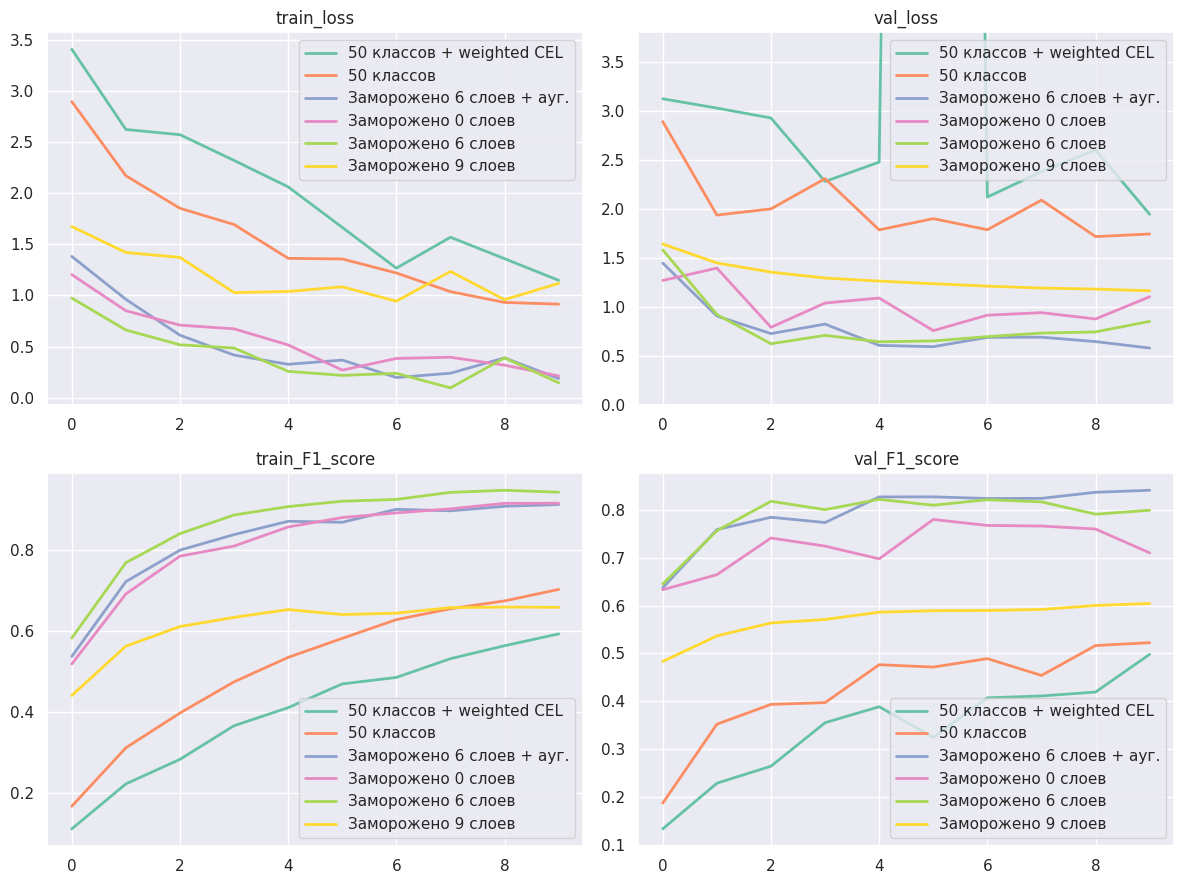

In [ ]:
runs = wandb.Api().runs("Artworks")
subplot_names = np.array([['train_loss', 'val_loss'],
                          ['train_F1_score', 'val_F1_score']])

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()
    axs[0, 1].set_ylim((0, 3.8))
plt.tight_layout()

**Вывод:** Мы попробовали fine-tuning для задачи классификации картин художников. Картины довольно сильно отличаются от естественных изображений, и лучшим способом дообучения оказалось зазморозить только 6 из 9 слоев модели, оставив большинство параметров обучаемыми. На широко представленных классах модель неплохо обучилась, достигнув значения метрики F1 `0.79` на тесте. При добавлении аугментации во время обучения метрика возросла до `0.84`. На всех классах модель показала более слабый результат и метрика достигла значения `0.52`. Дело в том, что на малопредставленных классах модель плохо выучилась. При изменении весов классов для вычисления лосса общая метрика понизилась, но метрика для малопредставленных классов возросла с `0.504` до `0.542`.